In [3]:
import cvxpy as cp
import cvxpylayers
import matplotlib.pyplot as plt
import torch
from algorithms import fit
from cvxpylayers.torch import CvxpyLayer
# from sklearn.linear_model import LogisticRegression
cp.__version__, cvxpylayers.__version__

('1.1.1', '0.1.4')

In [4]:
# Define convex optimization model
m = 2

y = cp.Variable(m)
units = cp.Variable(m)
t = cp.Variable(m)
alpha = cp.Parameter(m, nonneg=True)
inverse_p = cp.Parameter(m, nonneg=True)
B = cp.Parameter(nonneg=True)

objective = cp.sum(t)
constraints = [cp.sum(y) == B, y >= 0,
               -cp.exp(-cp.multiply(alpha, units)) >= cp.multiply(alpha, t),
               units == cp.multiply(y, inverse_p)]
prob = cp.Problem(cp.Maximize(objective), constraints)
layer = CvxpyLayer(prob, [B, inverse_p, alpha], [y])
prob


Problem(Maximize(Expression(AFFINE, UNKNOWN, ())), [Equality(Expression(AFFINE, UNKNOWN, ()), Parameter((), nonneg=True)), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, (2,))), Equality(Variable((2,)), Expression(AFFINE, UNKNOWN, (2,)))])

In [ ]:
# Get data
def get_data(N, m, alpha):
    P = torch.rand(N, m)
    B = torch.rand(N) * 10
    Y = layer(B, 1 / P, alpha)[0]
    Y = Y * (torch.rand_like(Y) + .5)
    Y = Y * B[:,None] / Y.sum(1)[:,None]
    return torch.cat([B.unsqueeze(1), P], axis=1), Y

torch.manual_seed(0)
alpha_true = torch.rand(m)
X, Y = get_data(100, m, alpha_true)
Xval, Yval = get_data(50, m, alpha_true)
Y[:3]

In [8]:
loss_fn = torch.nn.MSELoss()

In [9]:
torch.manual_seed(1)
alpha = torch.rand(m)
alpha.requires_grad_(True)
def loss(X, Y, alpha):
    Yhat = layer(X[:,0], 1. / X[:,1:], alpha)[0]
    return loss_fn(Y, Yhat)

def callback():
    alpha.data = torch.max(alpha.data, torch.zeros_like(alpha.data))

print(loss(X, Y, alpha_true), loss(Xval, Yval, alpha_true))
print(loss(X, Y, alpha), loss(Xval, Yval, alpha))

val_losses, train_losses = fit(lambda X, Y: loss(X, Y, alpha), [alpha], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr":1e-2},
                               batch_size=4, epochs=25, verbose=True, callback=callback)

tensor(0.0321) tensor(0.0282)
tensor(0.8471, grad_fn=<MeanBackward0>) tensor(0.7306, grad_fn=<MeanBackward0>)
001 | 0.73061
batch 001 / 025 | 0.95666
batch 002 / 025 | 1.00477
batch 003 / 025 | 0.94091
batch 004 / 025 | 0.84718
batch 005 / 025 | 0.89175
batch 006 / 025 | 0.85780
batch 007 / 025 | 0.78629
batch 008 / 025 | 0.71242
batch 009 / 025 | 0.75976
batch 010 / 025 | 0.71932
batch 011 / 025 | 0.68148
batch 012 / 025 | 0.64120
batch 013 / 025 | 0.62105
batch 014 / 025 | 0.59415
batch 015 / 025 | 0.57191
batch 016 / 025 | 0.56003
batch 017 / 025 | 0.54632
batch 018 / 025 | 0.52648
batch 019 / 025 | 0.52284
batch 020 / 025 | 0.50259
batch 021 / 025 | 0.49271
batch 022 / 025 | 0.48323
batch 023 / 025 | 0.46796
batch 024 / 025 | 0.45282
batch 025 / 025 | 0.43986
002 | 0.16678
batch 001 / 025 | 0.28634
batch 002 / 025 | 0.22062
batch 003 / 025 | 0.24235
batch 004 / 025 | 0.24114
batch 005 / 025 | 0.21736
batch 006 / 025 | 0.20842
batch 007 / 025 | 0.19694
batch 008 / 025 | 0.18609
batc

In [10]:
theta = torch.zeros(m + 1, m)
theta0 = torch.zeros(m, requires_grad=True)
theta.requires_grad_(True)
opt = torch.optim.LBFGS([theta, theta0], max_iter=500)
l = torch.nn.KLDivLoss()

def closure():
    opt.zero_grad()
    loss = l(torch.nn.LogSoftmax()(X @ theta + theta0), Y / Y.sum(1)[:,None])
    loss.backward()
    return loss

opt.step(closure)

<ipython-input-10-bf5cdb10a48c>:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l(torch.nn.LogSoftmax()(X @ theta + theta0), Y / Y.sum(1)[:,None])
/home/martin/anaconda3/envs/routing_identification/lib/python3.8/site-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(0.0506, grad_fn=<KlDivBackward>)

<ipython-input-14-5b8a16fb7d2f>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ax[0].axhline(loss_fn(torch.nn.Softmax()(Xval @ theta + theta0) * Xval[:,0][:,None], Yval).item(), linestyle='-.', c='black', label='LR')


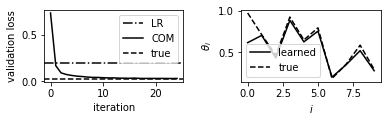

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(5.485, 1.8)

ax[0].axhline(loss_fn(torch.nn.Softmax()(Xval @ theta + theta0) * Xval[:,0][:,None], Yval).item(), linestyle='-.', c='black', label='LR')
ax[0].plot(val_losses, c='black', label='COM')
ax[0].axhline(loss(Xval, Yval, alpha_true).item(), linestyle='--', c='black', label='true')
ax[0].legend()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("validation loss")

ax[1].plot(alpha.detach().numpy(), c='black', label='learned')
ax[1].plot(alpha_true.detach().numpy(), '--', c='black', label='true')
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("$\\theta_i$")
ax[1].legend()

plt.tight_layout()

plt.savefig("figures/resource_allocation.pdf")